#Import thư viện

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install keras
!pip install tensorflow
!pip install scikeras

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import torch #pytorch
import torch.nn as nn
from torch.autograd import Variable
import matplotlib.pyplot as plt

# Đọc file data

In [4]:
df=pd.read_csv('data.csv')
idx=df.index.values
df=df[::-1]
df.index=idx

In [ ]:
df.head()

,Ngày,Giá điều chỉnh,Giá đóng cửa,Thay đổi,Khối lượng khớp lệnh,Giá trị khớp lệnh,KL thoả thuận,GT thoả thuận,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,03/01/2017,8.47,20.05,0.45(2.30 %),1300330,25952000000,700000,13972000000,19.60,20.15,19.55
1,04/01/2017,8.47,20.05,0(0.00 %),1224340,24592000000,0,0,20.05,20.25,19.90
2,05/01/2017,8.49,20.10,0.05(0.25 %),565830,11368000000,0,0,20.10,20.20,20.00
3,06/01/2017,8.58,20.30,0.2(1.00 %),2995300,61495000000,0,0,20.10,20.75,20.10
4,09/01/2017,8.66,20.50,0.2(0.99 %),886970,18174000000,0,0,20.30,20.60,20.30


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1737 entries, 0 to 1736
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Ngày                  1737 non-null   object 
 1   Giá điều chỉnh        1737 non-null   float64
 2   Giá đóng cửa          1737 non-null   float64
 3   Thay đổi              1737 non-null   object 
 4   Khối lượng khớp lệnh  1737 non-null   int64  
 5   Giá trị khớp lệnh     1737 non-null   int64  
 6   KL thoả thuận         1737 non-null   int64  
 7   GT thoả thuận         1737 non-null   int64  
 8   Giá mở cửa            1737 non-null   float64
 9   Giá cao nhất          1737 non-null   float64
 10  Giá thấp nhất         1737 non-null   float64
dtypes: float64(5), int64(4), object(2)
memory usage: 162.8+ KB


In [6]:
data=df.drop(columns=['Ngày','Thay đổi'])

In [7]:
data=data.drop(columns=['Khối lượng khớp lệnh','KL thoả thuận','GT thoả thuận'])

In [8]:
data

,Giá điều chỉnh,Giá đóng cửa,Giá trị khớp lệnh,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,8.47,20.05,25952000000,19.60,20.15,19.55
1,8.47,20.05,24592000000,20.05,20.25,19.90
2,8.49,20.10,11368000000,20.10,20.20,20.00
3,8.58,20.30,61495000000,20.10,20.75,20.10
4,8.66,20.50,18174000000,20.30,20.60,20.30
...,...,...,...,...,...,...
1732,32.60,32.60,591368000000,32.70,33.00,32.30
1733,32.70,32.70,649302000000,32.60,33.05,32.10
1734,32.60,32.60,406841000000,32.80,33.00,32.50
1735,32.00,32.00,700751000000,32.90,32.95,32.00


# Xây dựng model 1

## Tiền xử lý data

In [53]:
data_close = df.filter(['Giá điều chỉnh'])
# Convert the dataframe to a numpy array
dataset = data_close.values
# Get the number of rows to train the model on
training_data_len = int(np.ceil( len(dataset) * .9 ))
training_data_len

1564

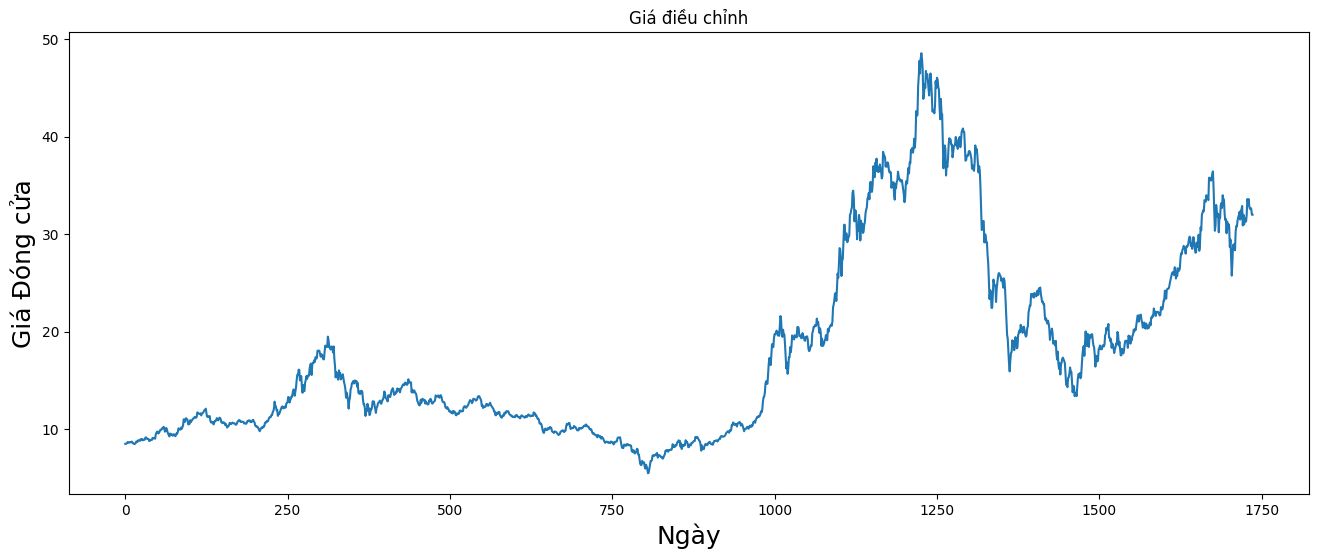

In [54]:
plt.figure(figsize=(16,6))
plt.title('Giá điều chỉnh')
plt.plot(data_close)
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá Đóng cửa', fontsize=18)
plt.show()

In [55]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.07000464],
       [0.07000464],
       [0.07046824],
       ...,
       [0.62934631],
       [0.61543811],
       [0.61543811]])

In [56]:
train_data = scaled_data[0:int(training_data_len), :]
train_data[0,:]

array([0.07000464])

In [57]:
# Create the training data set
# Create the scaled training data set
sequence_length=90
train_data = scaled_data[0:int(training_data_len), :]
# Split the data into x_train and y_train data sets
x_train = []
y_train = []

for i in range(sequence_length, len(train_data)):
    x_train.append(train_data[i-sequence_length:i, 0])
    y_train.append(train_data[i, 0])

# Convert the x_train and y_train to numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1474, 90, 1)

## Model compile & training

In [16]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

# Build the LSTM model
def model_create(optimizer='adam'):
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (sequence_length, 1)))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(32))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  return model
# Train the model
checkpoint_filepath = '/drive/MyDrive/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
model_1=model_create('adam')

model_1.fit(x_train,
          y_train,
          validation_split=0.1,
          batch_size=1,
          callbacks=[model_checkpoint_callback],
          epochs=20)
mode_1=load_model(checkpoint_filepath)
mode_1.save('/content/drive/My Drive/Colab_Models/LSTM_model_1.h5')

Epoch 1/20
1326/1326 [==============================] - 17s 10ms/step - loss: 0.0046 - val_loss: 8.8320e-04
Epoch 2/20
1326/1326 [==============================] - 13s 9ms/step - loss: 0.0019 - val_loss: 0.0014
Epoch 3/20
1326/1326 [==============================] - 13s 10ms/step - loss: 0.0019 - val_loss: 7.0816e-04
Epoch 4/20
1326/1326 [==============================] - 12s 9ms/step - loss: 0.0024 - val_loss: 0.0033
Epoch 5/20
1326/1326 [==============================] - 12s 9ms/step - loss: 0.0017 - val_loss: 4.8489e-04
Epoch 6/20
1326/1326 [==============================] - 13s 10ms/step - loss: 0.0016 - val_loss: 4.1469e-04
Epoch 7/20
1326/1326 [==============================] - 13s 9ms/step - loss: 0.0017 - val_loss: 9.9586e-04
Epoch 8/20
1326/1326 [==============================] - 12s 9ms/step - loss: 0.0014 - val_loss: 3.1456e-04
Epoch 9/20
1326/1326 [==============================] - 12s 9ms/step - loss: 0.0016 - val_loss: 5.2241e-04
Epoch 10/20
1326/1326 [===================

In [76]:
model_1.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 90, 128)           66560     
                                                                 
 dropout_2 (Dropout)         (None, 90, 128)           0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 118081 (461.25 KB)
Trainable params: 118

## Kiểm tra trên tập test với model vừa được train

In [58]:
# Create the testing data set
# Create a new array containing scaled values from index 1473 to 1735
test_data = scaled_data[training_data_len - sequence_length: , :]
# Create the data sets x_test and y_test
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(sequence_length, len(test_data)):
    x_test.append(test_data[i-sequence_length:i, 0])

# Convert the data to a numpy array
x_test = np.array(x_test)

# Reshape the data
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

# Get the models predicted price values
predictions = model_1.predict(x_test)
predictions = scaler.inverse_transform(predictions)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
rmse

6/6 [==============================] - 0s 7ms/step


1.4722052017387213

## Visualize kết quả

<ipython-input-60-0450787197dc>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions


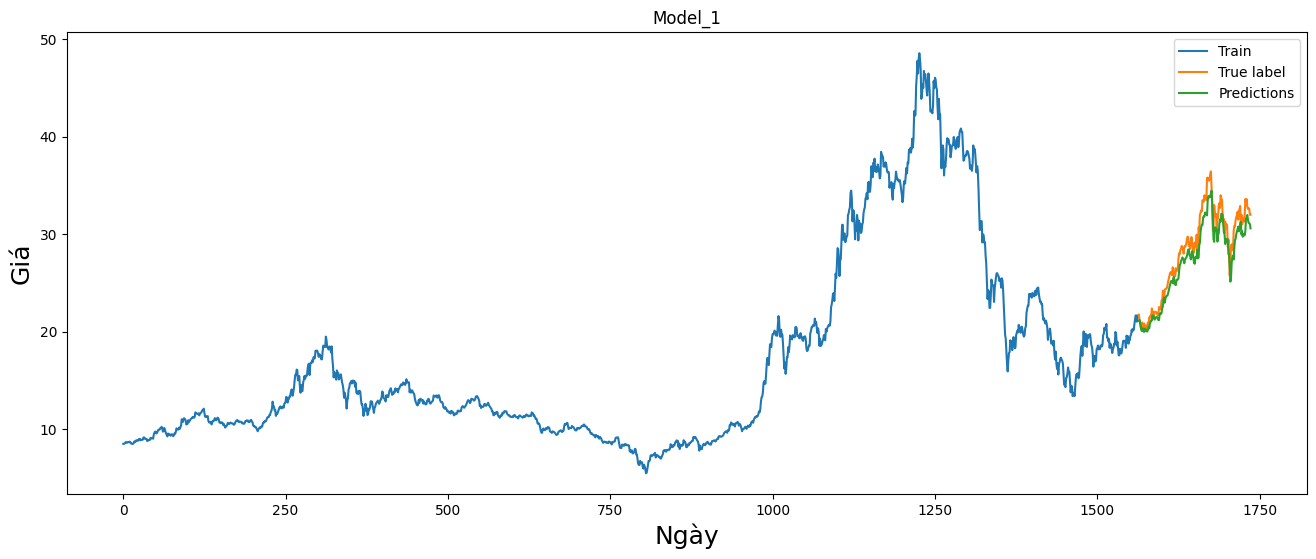

In [60]:
# Plot the data
train = data_close[:training_data_len]
valid = data_close[training_data_len:]
valid['Predictions'] = predictions
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model_1')
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá', fontsize=18)
plt.plot(train['Giá điều chỉnh'])
plt.plot(valid[['Giá điều chỉnh', 'Predictions']])
plt.legend(['Train', 'True label', 'Predictions'], loc='upper right')
plt.show()

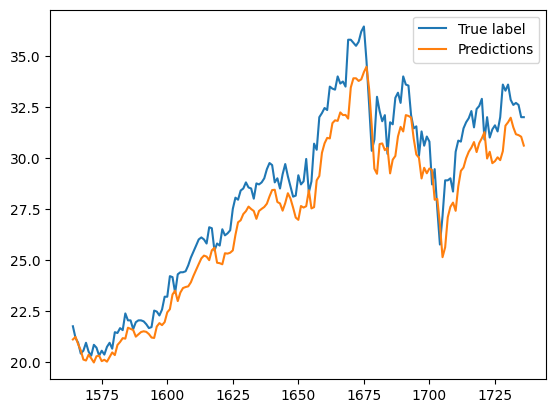

In [24]:
plt.plot(valid[['Giá điều chỉnh', 'Predictions']])
plt.legend(['True label', 'Predictions'], loc='upper right')
plt.show()

# Xây dựng model 2

## Tiền xử lý data

In [25]:
data.corr().style.background_gradient(cmap='coolwarm')


,Giá điều chỉnh,Giá đóng cửa,Giá trị khớp lệnh,Giá mở cửa,Giá cao nhất,Giá thấp nhất
Giá điều chỉnh,1.000000,0.776965,0.789448,0.777548,0.780193,0.774735
Giá đóng cửa,0.776965,1.000000,0.585683,0.997429,0.998879,0.998649
Giá trị khớp lệnh,0.789448,0.585683,1.000000,0.583898,0.595293,0.573551
Giá mở cửa,0.777548,0.997429,0.583898,1.000000,0.998917,0.998942
Giá cao nhất,0.780193,0.998879,0.595293,0.998917,1.000000,0.998576
Giá thấp nhất,0.774735,0.998649,0.573551,0.998942,0.998576,1.000000


In [61]:
data_close_2 = df.filter(['Giá điều chỉnh','Giá đóng cửa','Giá mở cửa','Giá cao nhất','Giá thấp nhất'])
# Convert the dataframe to a numpy array
dataset_2 = data_close_2.values
# Get the number of rows to train the model on
training_data_len_2 = int(np.ceil( len(dataset_2) * .9 ))
training_data_len_2

1564

In [62]:
data_close_2

,Giá điều chỉnh,Giá đóng cửa,Giá mở cửa,Giá cao nhất,Giá thấp nhất
0,8.47,20.05,19.60,20.15,19.55
1,8.47,20.05,20.05,20.25,19.90
2,8.49,20.10,20.10,20.20,20.00
3,8.58,20.30,20.10,20.75,20.10
4,8.66,20.50,20.30,20.60,20.30
...,...,...,...,...,...
1732,32.60,32.60,32.70,33.00,32.30
1733,32.70,32.70,32.60,33.05,32.10
1734,32.60,32.60,32.80,33.00,32.50
1735,32.00,32.00,32.90,32.95,32.00


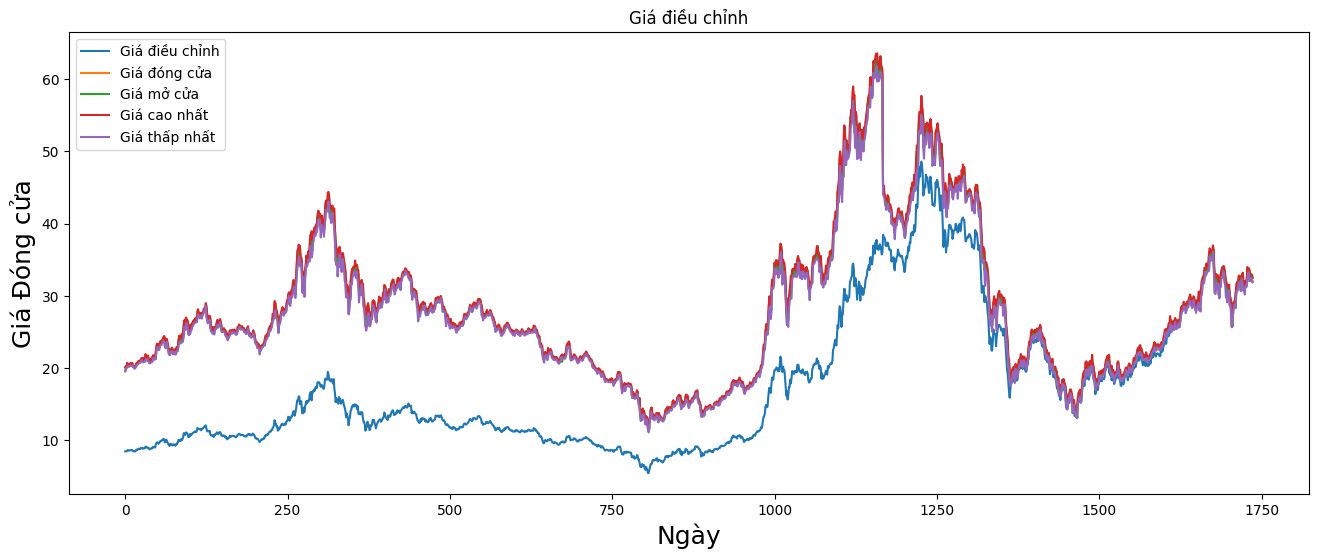

In [63]:
plt.figure(figsize=(16,6))
plt.title('Giá điều chỉnh')
plt.plot(data_close_2)
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá Đóng cửa', fontsize=18)
plt.legend(['Giá điều chỉnh','Giá đóng cửa','Giá mở cửa','Giá cao nhất','Giá thấp nhất'],loc='upper left')
plt.show()

In [64]:
scaler_2 = MinMaxScaler(feature_range=(0,1))
scaled_data_2 = scaler_2.fit_transform(dataset_2)
#scaled_data =dataset

In [65]:
train_data_2 = scaled_data_2[0:int(training_data_len_2), :]
train_data_2.shape

(1564, 5)

In [66]:
# Create the training data set
# Create the scaled training data set
train_data_2 = scaled_data_2[0:int(training_data_len_2), :]
# Split the data into x_train and y_train data sets
x_train_2 = []
y_train_2 = []

for i in range(sequence_length, len(train_data_2)):
    x_train_2.append(train_data_2[i-sequence_length:i, :])
    y_train_2.append(train_data_2[i,0])

# Convert the x_train and y_train to numpy arrays
x_train_2, y_train_2 = np.array(x_train_2), np.array(y_train_2)

# Reshape the data
x_train_2 = np.reshape(x_train_2, (x_train_2.shape[0], x_train_2.shape[1], 5))
x_train_2.shape

(1474, 90, 5)

## Model compile & training

In [74]:
def model_create(optimizer='adam'):
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (sequence_length, 5)))
  model.add(Dropout(0.2))
  model.add(LSTM(128, return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dropout(0.2))
  model.add(Dense(32))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer=optimizer, loss='mean_squared_error')
  return model
model_2=model_create('adam')
checkpoint_filepath = '/drive/MyDrive/checkpoint.model.keras'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
model_2.fit(x_train_2,
          y_train_2,
          validation_split=0.1,
          batch_size=8,
          callbacks=[model_checkpoint_callback],
          epochs=20)
mode_2=load_model(checkpoint_filepath)
mode_2.save('/content/drive/My Drive/Colab_Models/LSTM_model_2.h5')

Epoch 1/20
166/166 [==============================] - 9s 24ms/step - loss: 0.0071 - val_loss: 0.0011
Epoch 2/20
166/166 [==============================] - 3s 19ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 3/20
166/166 [==============================] - 3s 16ms/step - loss: 0.0024 - val_loss: 0.0015
Epoch 4/20
166/166 [==============================] - 2s 13ms/step - loss: 0.0024 - val_loss: 7.3464e-04
Epoch 5/20
166/166 [==============================] - 2s 14ms/step - loss: 0.0018 - val_loss: 6.3697e-04
Epoch 6/20
166/166 [==============================] - 2s 14ms/step - loss: 0.0014 - val_loss: 0.0015
Epoch 7/20
166/166 [==============================] - 2s 14ms/step - loss: 0.0014 - val_loss: 6.9850e-04
Epoch 8/20
166/166 [==============================] - 3s 19ms/step - loss: 0.0017 - val_loss: 5.9986e-04
Epoch 9/20
166/166 [==============================] - 3s 16ms/step - loss: 0.0014 - val_loss: 6.4149e-04
Epoch 10/20
166/166 [==============================] - 2s 13ms/step - l

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [77]:
model_2.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_22 (LSTM)              (None, 90, 128)           68608     
                                                                 
 dropout_22 (Dropout)        (None, 90, 128)           0         
                                                                 
 lstm_23 (LSTM)              (None, 90, 128)           131584    
                                                                 
 dropout_23 (Dropout)        (None, 90, 128)           0         
                                                                 
 lstm_24 (LSTM)              (None, 64)                49408     
                                                                 
 dropout_24 (Dropout)        (None, 64)                0         
                                                                 
 dense_16 (Dense)            (None, 32)               

## Kiểm tra trên tập test với model vừa được train

In [68]:
# Create the testing data set
test_data_2 = scaled_data_2[training_data_len_2 - sequence_length: , :]
# Create the data sets x_test and y_test
x_test_2 = []
y_test_2 = dataset_2[training_data_len_2:, 0]
for i in range(sequence_length, len(test_data_2)):
    x_test_2.append(test_data_2[i-sequence_length:i, :])

# Convert the data to a numpy array
x_test_2 = np.array(x_test_2)

# Reshape the data
x_test_2 = np.reshape(x_test_2, (x_test_2.shape[0], x_test_2.shape[1], 5 ))

# Get the models predicted price values
predictions_2 = model_2.predict(x_test_2)
# inverse transform prediction
scaler_pred = MinMaxScaler(feature_range=(0,1))
scaler_pred.min_, scaler_pred.scale_ = scaler_2.min_[1], scaler_2.scale_[1]

predictions_2 = scaler_pred.inverse_transform(predictions_2)

# Get the root mean squared error (RMSE)
rmse = np.sqrt(np.mean(((predictions_2 - y_test_2) ** 2)))
rmse

6/6 [==============================] - 0s 16ms/step


12.542117509124026

## Visualize kết quả

<ipython-input-78-56c60e923c67>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = predictions_2


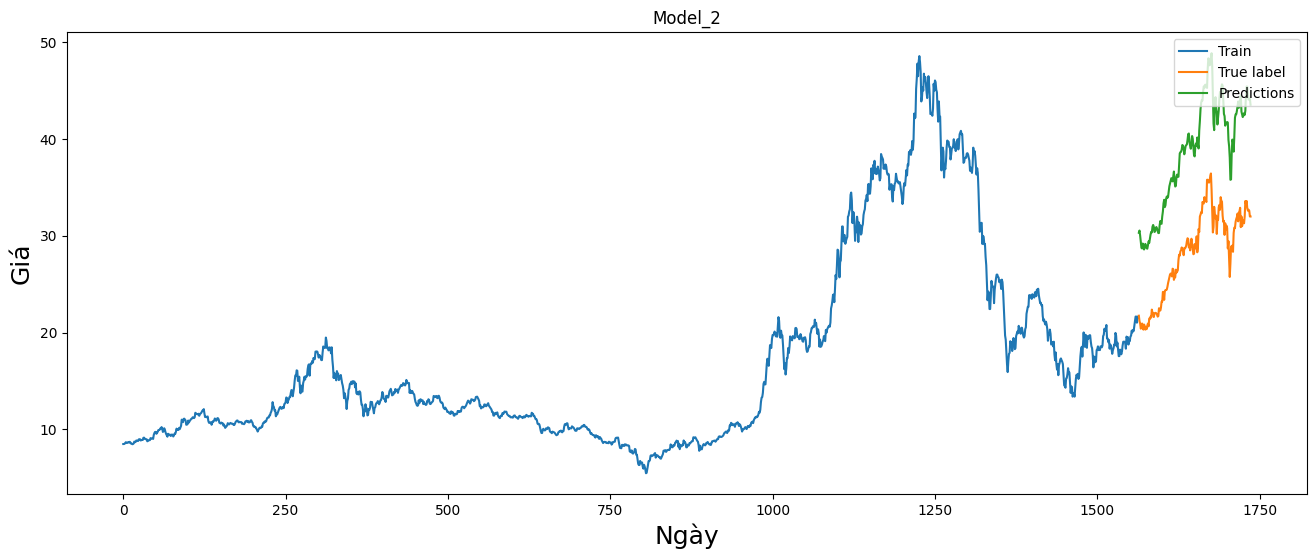

In [78]:
# Plot the data
train = data_close_2[:training_data_len]
valid = data_close_2[training_data_len:]
valid['Predictions'] = predictions_2
# Visualize the data
plt.figure(figsize=(16,6))
plt.title('Model_2')
plt.xlabel('Ngày', fontsize=18)
plt.ylabel('Giá', fontsize=18)
plt.plot(train['Giá điều chỉnh'])
plt.plot(valid[['Giá điều chỉnh', 'Predictions']])
plt.legend(['Train', 'True label', 'Predictions'], loc='upper right')
plt.show()


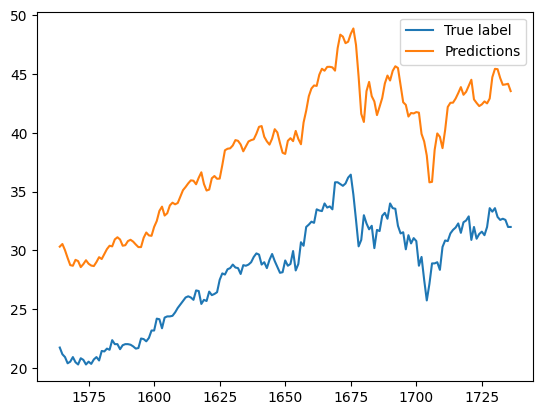

In [72]:
plt.plot(valid[['Giá điều chỉnh', 'Predictions']])
plt.legend(['True label', 'Predictions'], loc='upper right')
plt.show()